Project2-Augmentation_CutMix_Mixup
===
---

목표: 적은 데이터셋을 해결방법인 Agumentation에서 최신 기법인 CutMix 와 Mixup 을 적용하여 성능 차이를 비교해보자.

데이터 : tensorflow dataset `stanford_dogs` 
- 120개 견종의 이미지
- 총 20,580장의 이미지 
- 12,000장 학습셋 
- 나머지 8,580장 평가용 데이터셋

모델 : resnet


## 1. Augmentation을 적용한 데이터셋 만들기

#### 라이브러리 실행

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

#### 학습 전 GPU 환경을 확인

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### 데이터 불러오기

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

#### 예시 확인해보기

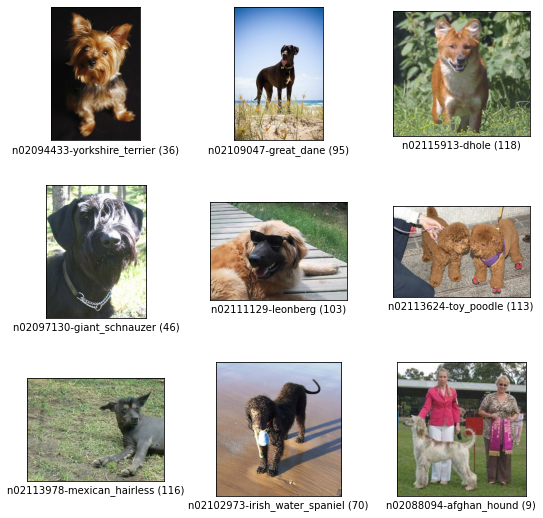

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

#### Augmentation을 적용하기에 앞서 기본적인 전처리 함수를 만들어주기

In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

#### `random_flip_left_right()`과 `random_brightness()`를 적용하는 함수만들기

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

#### CutMix에서 이미지를 자를 부분을 설정해주는 `get_clip_box`함수 만들기

In [7]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

#### CutMix에서 이미지를 자르는 `mix_2_images`함수 만들기

In [8]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

#### CutMix에서 라벨을 이미지 영역의 비만큼 섞어주는 `mix_2_label`함수 만들기

In [9]:
# mix two labels
def mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b #
    return mixed_label

#### CutMix를 적용해주는 함수 만들기

In [10]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### Mixup함수에서 이미지를 섞어주는 `mixup_2_image`함수 만들기

In [11]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

#### Mixup 함수만들기

In [12]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### 기본 데이터와 Augmentation된 데이터의 label에도 one hot encoding을 적용해주는 `onehot` 함수 만들기

In [13]:
def onehot(image, label, num_classes=120):

    onehot_label = tf.one_hot(label, num_classes)

    return image, onehot_label

#### 데이터에 대해서 조건에 따라 기본, Augmentation, CutMix, Mixup을 적용해주는 함수 만들기

In [14]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    
    if not with_cutmix and not with_mixup:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 2. 모델 만들기

#### 텐서플로우 케라스의 ResNet50 중 imagenet에 훈련된 모델을 불러오기

In [15]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

#### Augmentation을 적용한 데이터셋으로 학습시킬 ResNet 만들어주기

In [16]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

#### CutMix을 적용한 데이터셋으로 학습시킬 ResNet 만들어주기

In [17]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

#### Mixup을 적용한 데이터셋으로 학습시킬 ResNet 만들어주기

In [18]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

#### 텐서플로우 데이터셋에서 불러온 데이터에 train-기본, train-augmentation, train-CutMix, train-Mixup, test 만들어주기 

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

다섯 가지 데이터에 대해 Augmentation이 어느것이 진행되었는지 확인해보기

|function|with_aug=False|with_aug=True|with_cutmix=True|with_mixup=True|is_test=True|
|:---:|:---:|:---:|:---:|:---:|:---:|
|nor_and_res|O|O|O|O|O|
|augment|X|O|X|X|X|
|batch|O|O|O|O|O|
|cutmix|X|X|O|X|X|
|mixup|X|X|X|O|X|
|onehot|O|O|X|X|O|
|repeat()|O|O|O|O|X|
|shuffle()|O|O|O|O|X|
|prefetch()|O|O|O|O|O|

## 3. 모델 훈련하기

#### 기본 데이터 훈련

In [20]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

tf.random.set_seed(2020)

resnet50.summary()

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 156s 158ms/step - loss: 3.2013 - accuracy: 0.2676 - val_loss: 3.6142 - val_accuracy: 0.1589
Epoch 2/20
750/750 [==============================] - 109s 146ms/step - loss: 0.9696 - accuracy: 0.7280 - val_loss: 1.1059 - val_accuracy: 0.6750
Epoch 3/20
750/750 [==============================] - 110s 146ms/step - loss: 0.3883 - accuracy: 0.8963 - val_loss: 0.9579 - val_accuracy: 0.7191
Epoch 4/20
750/750 [==============================] - 110s 147m

#### Augmentation 데이터 훈련

In [21]:
aug_resnet50.summary()

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 115s 148ms/step - loss: 3.1965 - accuracy: 0.2678 - val_loss: 3.1661 - val_accuracy: 0.2358
Epoch 2/20
750/750 [==============================] - 110s 147ms/step - loss: 1.1072 - accuracy: 0.6825 - val_loss: 1.2078 - val_accuracy: 0.6482
Epoch 3/20
750/750 [==============================] - 110s 147ms/step - loss: 0.6394 - accuracy: 0.8190 - val_loss: 1.0829 - val_accuracy: 0.6814
Epoch 4/20
750/750 [==============================] - 110s 14

#### cutmix 데이터 훈련

In [22]:
cutmix_resnet50.summary()

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = aug_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 116s 150ms/step - loss: 2.4248 - accuracy: 0.6412 - val_loss: 1.4457 - val_accuracy: 0.6245
Epoch 2/20
750/750 [==============================] - 112s 150ms/step - loss: 2.2048 - accuracy: 0.6883 - val_loss: 1.1851 - val_accuracy: 0.6860
Epoch 3/20
750/750 [==============================] - 112s 150ms/step - loss: 2.1299 - accuracy: 0.7098 - val_loss: 1.2784 - val_accuracy: 0.6610
Epoch 4/20
750/750 [==============================] - 113s 15

#### mixup 데이터 훈련

In [23]:
mixup_resnet50.summary()

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = aug_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 115s 151ms/step - loss: 1.8722 - accuracy: 0.8336 - val_loss: 1.4576 - val_accuracy: 0.6713
Epoch 2/20
750/750 [==============================] - 114s 151ms/step - loss: 1.8309 - accuracy: 0.8384 - val_loss: 1.6374 - val_accuracy: 0.6306
Epoch 3/20
750/750 [==============================] - 114s 151ms/step - loss: 1.8049 - accuracy: 0.8421 - val_loss: 1.6178 - val_accuracy: 0.6381
Epoch 4/20
750/750 [==============================] - 114s 15

## 4. 훈련과정 시각화하기

#### 4 가지 데이터에 대해 시각화

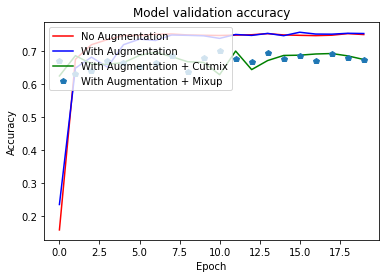

In [24]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'p')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + Cutmix', 'With Augmentation + Mixup'], loc='upper left')
plt.show()


#### 조금 더 확대해 살펴보기

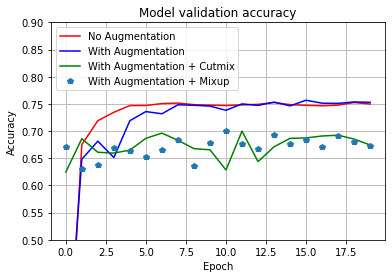

In [25]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'p')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + Cutmix', 'With Augmentation + Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.90)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## 5. Augmentation에 의한 모델 성능 비교



## 회고

#### apply_normalize_on_dataset 함수 만들기의 어려움
- onehot 함수 만들기
    - 이것이 무슨 역할을 해주도록 만들어야 할까를 한참을 고민했다. 양창원님 (A.K.A 빛나는 샤트님)과 금요일밤과 토요일밤을 불사르며 cutmix와 mixup이 적용되지 않는 데이터의 label에 대해 **onehot encoding을 해주는 함수**라는 것으로 확정하였다. 이를 적용해주기 위해 tf.one_hot을 적용해주었다.
    - 이 함수가 cutmix와 mixup이 아닌 데이터에 적용되도록 하기 위해서 **if not with_cutmix and not with_mixup:구문을 만들어냈다**... 논리회로 공부를 해야할 듯 하다...
    
- cutmix 함수 수정해주기
    - mix_2_label 함수의 input으로 image_a와 image_b를 정의해주지 않아서 오류가 발생하였다. 이를 해결해주기 위해 **input 변수로 image_a와 image_b를 넣어주었다.** 
    - CutMix 함수에서 **return값이 mixed_labels이 아니라 mixed_label로 되어 있어서 에러가 났다.** 이거는.. QA팀에게 문의를 해야하지 않나?라는 생각이 들었다.
    



## 루브릭


- CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.
    - 처음과는 크게 다르지 않지만 수렴한 모습을 확인하였다.


- Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함
    - 향상은 보이지 않는 듯 하다.


- 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.
    - 시각화 결과를 확인할 수 있다.